In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple EncoderDecoder

## Installations

In [2]:
# requirements = """
# keras
# git+https://www.github.com/keras-team/keras-contrib.git
# matplotlib
# numpy
# scipy
# pillow
# #urllib
# #skimage
# scikit-image
# #gzip
# #pickle
# """
# %store requirements > requirements.txt

In [3]:
# !pip install -r requirements.txt

## Import TensorFlow and other libraries

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

# !pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.preprocessing.image import img_to_array, load_img
from random import shuffle
import PIL
import json
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use('TKAgg')
%matplotlib inline

Using TensorFlow backend.


## Load the dataset

Steps to generate URL used below:
- Say, your data files are in the directory called 'input'
- Manually create a zip file, 'input.zip'
- Sync it to gDrive
- In gDrive, Share it with Public model, copy its share-able link
- Use https://sites.google.com/site/gdocs2direct/ to generate corresponding Direct link
- Paste it below

In [35]:
# test PIL installation
import sys
from PIL import Image
sys.modules['Image'] = Image

# both should point to same dir
from PIL import Image
print(Image.__file__)

import Image
print(Image.__file__)

C:\Continuum\anaconda3\envs\odsc_ws\lib\site-packages\PIL\Image.py
C:\Continuum\anaconda3\envs\odsc_ws\lib\site-packages\PIL\Image.py


In [36]:
# working directory
wdir = os.getcwd()
wdir

'C:\\Continuum\\anaconda3\\envs\\odsc_ws\\notebooks\\MidcurveNN-master'

In [37]:
# _URL = 'https://drive.google.com/uc?export=download&id=16rqDFLO__WySSQGlAht0FEj2uJZg4M9M'

# path_to_zip = tf.keras.utils.get_file('input.zip',
#                                       origin=_URL,
#                                       extract=True)

# input_data_folder = os.path.join(os.path.dirname(path_to_zip), 'input')
#input_data_folder = "D:/Yogesh/ToDos/Research/MidcurveNN/code/data/input"
input_data_folder = wdir + "\data\input"

In [38]:
def read_input_image_pairs(datafolder=input_data_folder):
    profile_pngs = []
    midcurve_pngs = []
    for file in os.listdir(datafolder):
        fullpath = os.path.join(datafolder, file)
        if os.path.isdir(fullpath):
            continue
        if file.endswith(".png"):
            if file.find("Profile") != -1:
                profile_pngs.append(fullpath)
            if file.find("Midcurve") != -1:
                midcurve_pngs.append(fullpath)
    profile_pngs = sorted(profile_pngs)
    midcurve_pngs = sorted(midcurve_pngs)
    return profile_pngs,midcurve_pngs

In [39]:
def get_training_data(datafolder = input_data_folder):
    profile_pngs,midcurve_pngs = read_input_image_pairs(datafolder)
    
    profile_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in profile_pngs ]
    midcurve_pngs_objs = [img_to_array(load_img(f, color_mode='rgba', target_size=(100, 100))) for f in midcurve_pngs]

#     profile_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in profile_pngs_objs])
#     midcurve_pngs_objs = np.array([x.reshape((1,) + x.shape) for x in midcurve_pngs_objs])

    profile_pngs_gray_objs = [x[:,:,3] for x in profile_pngs_objs]
    midcurve_pngs_gray_objs =[x[:,:,3] for x in midcurve_pngs_objs]
    
#     profile_pngs_gray_objs = [np.where(x>128, 0, 1) for x in profile_pngs_gray_objs]
#     midcurve_pngs_gray_objs =[np.where(x>128, 0, 1) for x in midcurve_pngs_gray_objs]
        
    # shufle them
    zipped_profiles_midcurves = [(p,m) for p,m in zip(profile_pngs_gray_objs,midcurve_pngs_gray_objs)]
    shuffle(zipped_profiles_midcurves)
    profile_pngs_gray_objs, midcurve_pngs_gray_objs = zip(*zipped_profiles_midcurves)
    
    return profile_pngs_gray_objs, midcurve_pngs_gray_objs

In [40]:
profile_pngs_objs, midcurve_pngs_objs = get_training_data()

In [12]:
def plot_results(original_imgs,computed_imgs):
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(computed_imgs[i].reshape(100, 100),cmap='gray_r')
#         plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

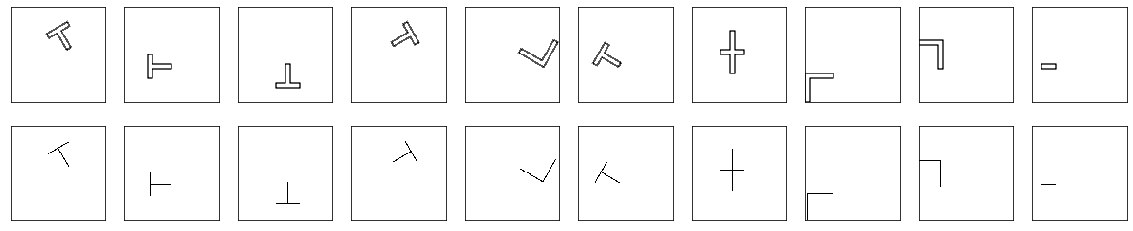

In [13]:
plot_results(profile_pngs_objs,midcurve_pngs_objs)

In [43]:
from keras import regularizers
from keras.layers import Input, Dense
from keras.models import Model, load_model
from prepare_data import get_training_data
from prepare_plots import plot_results
import os
import numpy as np
import sys
import random

np.set_printoptions(threshold=sys.maxsize)

class simple_encoderdecoder:
    def __init__(self):
        self.encoding_dim = 100
        self.input_dim = 10000
        self.epochs = 200
        self.autoencoder_model_pkl = wdir + "\data\models\autoencoder_model.pkl"
        self.encoder_model_pkl = wdir + "\data\models\encoder_model.pkl"
        self.decoder_model_pkl = wdir + "\data\models\decoder_model.pkl"
                
    def process_images(self,grayobjs):
        flat_objs = [x.reshape(self.input_dim) for x in grayobjs]
        pngs_objs = np.array(flat_objs)
        return pngs_objs

    def train(self,
            profile_pngs_gray_objs, 
            midcurve_pngs_gray_objs):
        
        if not os.path.exists(self.autoencoder_model_pkl):
            # this is our input placeholder
            input_img = Input(shape=(self.input_dim,))
            
            # "encoded" is the encoded representation of the input
            encoded = Dense(self.encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)
            # "decoded" is the lossy reconstruction of the input
            decoded = Dense(self.input_dim, activation='sigmoid')(encoded) 
            
            # Model 1: Full AutoEncoder, includes both encoder single dense layer and decoder single dense layer. 
            # This model maps an input to its reconstruction
            self.autoencoder = Model(input_img, decoded)
                    
            # Model 2: a separate encoder model: -------------------
            # this model maps an input to its encoded representation
            self.encoder = Model(input_img, encoded)
            
            # Model 3: a separate encoder model: -------------------
            # create a placeholder for an encoded (32-dimensional) input
            encoded_input = Input(shape=(self.encoding_dim,))
            # retrieve the last layer of the autoencoder model
            decoder_layer = self.autoencoder.layers[-1]
            # create the decoder model
            self.decoder = Model(encoded_input, decoder_layer(encoded_input))
            
            # Compilation of Autoencoder (only)
            self.autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
            
#             # Training
#             profile_pngs_flat_objs = [x.reshape(self.input_dim) for x in profile_pngs_gray_objs]
#             midcurve_pngs_flat_objs = [x.reshape(self.input_dim) for x in midcurve_pngs_gray_objs]
#             
#             profile_pngs_objs = np.array(profile_pngs_flat_objs)
#             midcurve_pngs_objs= np.array(midcurve_pngs_flat_objs)
#             
            profile_pngs_objs = self.process_images(profile_pngs_gray_objs)
            midcurve_pngs_objs = self.process_images(midcurve_pngs_gray_objs)
            
#             train_size = int(len(profile_pngs_objs)*0.7)
#             self.x_train = profile_pngs_objs[:train_size]
#             self.y_train = midcurve_pngs_objs[:train_size]
#             self.x_test = profile_pngs_objs[train_size:]
#             self.y_test = midcurve_pngs_objs[train_size:]
#             self.autoencoder.fit(self.x_train, self.y_train,
#                         epochs=self.epochs,
#                         batch_size=5,
#                         shuffle=True,
#                         validation_data=(self.x_test, self.y_test))
                
            self.x = profile_pngs_objs
            self.y = midcurve_pngs_objs
            self.autoencoder.fit(self.x, self.y,
                        epochs=self.epochs,
                        batch_size=5,
                        shuffle=True)                
            # Save models
            self.autoencoder.save(self.autoencoder_model_pkl)
            self.encoder.save(self.encoder_model_pkl)
            self.decoder.save(self.decoder_model_pkl)  
        else:
            # Save models
            self.autoencoder = load_model(self.autoencoder_model_pkl)
            self.encoder= load_model(self.encoder_model_pkl)
            self.decoder = load_model(self.decoder_model_pkl)
    
    def predict(self, test_profile_images):
        png_profile_images = self.process_images(test_profile_images)
        encoded_imgs = self.encoder.predict(png_profile_images)
        decoded_imgs = self.decoder.predict(encoded_imgs)    
        return test_profile_images,decoded_imgs  

Epoch 1/200
448/448 [==============================] - 3s 8ms/step - loss: -3.0615
Epoch 2/200
448/448 [==============================] - 3s 6ms/step - loss: -12.8917
Epoch 3/200
448/448 [==============================] - 3s 6ms/step - loss: -15.0182A: 0s - loss: -14
Epoch 4/200
448/448 [==============================] - 3s 6ms/step - loss: -15.6901
Epoch 5/200
448/448 [==============================] - 3s 7ms/step - loss: -16.0536A: 0s - loss: -16.
Epoch 6/200
448/448 [==============================] - 3s 6ms/step - loss: -16.3270
Epoch 7/200
448/448 [==============================] - 3s 6ms/step - loss: -16.4829
Epoch 8/200
448/448 [==============================] - 3s 6ms/step - loss: -16.6132
Epoch 9/200
448/448 [==============================] - 3s 6ms/step - loss: -16.6836
Epoch 10/200
448/448 [==============================] - 3s 6ms/step - loss: -16.7303
Epoch 11/200
448/448 [==============================] - 3s 6ms/step - loss: -16.7797
Epoch 12/200
448/448 [==================

448/448 [==============================] - 2s 5ms/step - loss: -17.2603
Epoch 95/200
448/448 [==============================] - 2s 5ms/step - loss: -17.2554
Epoch 96/200
448/448 [==============================] - 2s 5ms/step - loss: -17.2613
Epoch 97/200
448/448 [==============================] - 2s 5ms/step - loss: -17.2678
Epoch 98/200
448/448 [==============================] - 2s 5ms/step - loss: -17.2538
Epoch 99/200
448/448 [==============================] - 2s 5ms/step - loss: -17.2619
Epoch 100/200
448/448 [==============================] - 2s 5ms/step - loss: -17.2619
Epoch 101/200
448/448 [==============================] - ETA: 0s - loss: -17.200 - 2s 5ms/step - loss: -17.2712
Epoch 102/200
448/448 [==============================] - 2s 5ms/step - loss: -17.2871
Epoch 103/200
448/448 [==============================] - 2s 5ms/step - loss: -17.2864
Epoch 104/200
448/448 [==============================] - 2s 5ms/step - loss: -17.2570
Epoch 105/200
448/448 [========================

448/448 [==============================] - 3s 6ms/step - loss: -17.3656
Epoch 186/200
448/448 [==============================] - 3s 6ms/step - loss: -17.3792
Epoch 187/200
448/448 [==============================] - 3s 6ms/step - loss: -17.3617
Epoch 188/200
448/448 [==============================] - 3s 6ms/step - loss: -17.3396
Epoch 189/200
448/448 [==============================] - 3s 6ms/step - loss: -17.3645
Epoch 190/200
448/448 [==============================] - 3s 6ms/step - loss: -17.3639
Epoch 191/200
448/448 [==============================] - 2s 6ms/step - loss: -17.3483A: 0s - loss: -
Epoch 192/200
448/448 [==============================] - 3s 6ms/step - loss: -17.3670
Epoch 193/200
448/448 [==============================] - 3s 6ms/step - loss: -17.3590
Epoch 194/200
448/448 [==============================] - 3s 6ms/step - loss: -17.3850
Epoch 195/200
448/448 [==============================] - 3s 6ms/step - loss: -17.3670
Epoch 196/200
448/448 [==============================

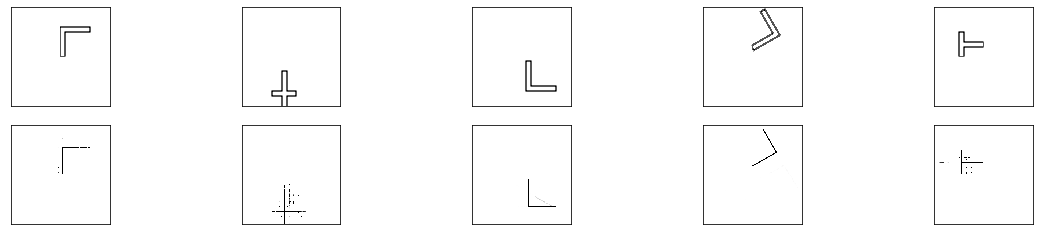

In [18]:
profile_gray_objs, midcurve_gray_objs = get_training_data()
endec = simple_encoderdecoder()
endec.train(profile_gray_objs, midcurve_gray_objs)
    
test_gray_images = random.sample(profile_gray_objs,5)
original_profile_imgs,predicted_midcurve_imgs = endec.predict(test_gray_images)
plot_results(original_profile_imgs,predicted_midcurve_imgs)